## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.9 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 7:1:2
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 14:40:01,920] A new study created in memory with name: no-name-80bda49d-e063-468e-b2d1-ba58ce9d9c7d


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 14:40:14,687] Trial 0 finished with value: 22.109711396817595 and parameters: {'window_size': 83, 'tcn_filters': 124, 'tcn_kernel_size': 5, 'dropout_rate': 0.27814141606395176, 'attention_dim': 22}. Best is trial 0 with value: 22.109711396817595.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-14 14:40:23,002] Trial 1 finished with value: 24.29176428505579 and parameters: {'window_size': 50, 'tcn_filters': 68, 'tcn_kernel_size': 3, 'dropout_rate': 0.35102416887112864, 'attention_dim': 18}. Best is trial 0 with value: 22.109711396817595.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 14:40:29,421] Trial 2 finished with value: 5.963512434054598 and parameters: {'window_size': 30, 'tcn_filters': 120, 'tcn_kernel_size': 2, 'dropout_rate': 0.48395737498840774, 'attention_dim': 32}. Best is trial 2 with value: 5.963512434054598.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:40:36,142] Trial 3 finished with value: 39.10959120203488 and parameters: {'window_size': 93, 'tcn_filters': 81, 'tcn_kernel_size': 2, 'dropout_rate': 0.32436669931424034, 'attention_dim': 20}. Best is trial 2 with value: 5.963512434054598.


4/4 [==============================] - 0s 5ms/step


[I 2023-06-14 14:40:39,994] Trial 4 finished with value: 62.6672444696904 and parameters: {'window_size': 100, 'tcn_filters': 39, 'tcn_kernel_size': 2, 'dropout_rate': 0.20018318734553175, 'attention_dim': 20}. Best is trial 2 with value: 5.963512434054598.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 14:40:44,832] Trial 5 finished with value: 22.33704595472113 and parameters: {'window_size': 56, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.281410072456897, 'attention_dim': 20}. Best is trial 2 with value: 5.963512434054598.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 14:40:51,400] Trial 6 finished with value: 5.34085395819841 and parameters: {'window_size': 36, 'tcn_filters': 68, 'tcn_kernel_size': 4, 'dropout_rate': 0.34108104998429056, 'attention_dim': 18}. Best is trial 6 with value: 5.34085395819841.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:40:56,239] Trial 7 finished with value: 6.638283538471341 and parameters: {'window_size': 53, 'tcn_filters': 65, 'tcn_kernel_size': 4, 'dropout_rate': 0.48484700833562633, 'attention_dim': 11}. Best is trial 6 with value: 5.34085395819841.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 14:41:08,105] Trial 8 finished with value: 4.058497476917027 and parameters: {'window_size': 64, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.3477574926376892, 'attention_dim': 23}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-14 14:41:12,220] Trial 9 finished with value: 33.04113282968867 and parameters: {'window_size': 48, 'tcn_filters': 43, 'tcn_kernel_size': 3, 'dropout_rate': 0.24806618265695307, 'attention_dim': 19}. Best is trial 8 with value: 4.058497476917027.


7/7 [==============================] - 0s 2ms/step


[I 2023-06-14 14:41:15,043] Trial 10 finished with value: 21.685396332958696 and parameters: {'window_size': 10, 'tcn_filters': 100, 'tcn_kernel_size': 5, 'dropout_rate': 0.1439193878372183, 'attention_dim': 29}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:41:25,414] Trial 11 finished with value: 5.438842905515194 and parameters: {'window_size': 68, 'tcn_filters': 90, 'tcn_kernel_size': 4, 'dropout_rate': 0.3792074865699832, 'attention_dim': 26}. Best is trial 8 with value: 4.058497476917027.


7/7 [==============================] - 1s 3ms/step


[I 2023-06-14 14:41:32,255] Trial 12 finished with value: 9.064492953218997 and parameters: {'window_size': 28, 'tcn_filters': 61, 'tcn_kernel_size': 4, 'dropout_rate': 0.393692467862681, 'attention_dim': 14}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:41:41,304] Trial 13 finished with value: 6.125856213743132 and parameters: {'window_size': 70, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.4103342891628996, 'attention_dim': 25}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:41:45,409] Trial 14 finished with value: 22.548513148502227 and parameters: {'window_size': 35, 'tcn_filters': 84, 'tcn_kernel_size': 5, 'dropout_rate': 0.3261981655492332, 'attention_dim': 15}. Best is trial 8 with value: 4.058497476917027.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 14:41:51,838] Trial 15 finished with value: 9.694444305829462 and parameters: {'window_size': 11, 'tcn_filters': 72, 'tcn_kernel_size': 3, 'dropout_rate': 0.42777379478460337, 'attention_dim': 9}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 14:41:55,743] Trial 16 finished with value: 20.529128253558227 and parameters: {'window_size': 70, 'tcn_filters': 51, 'tcn_kernel_size': 4, 'dropout_rate': 0.3494237945309388, 'attention_dim': 24}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:42:01,772] Trial 17 finished with value: 14.35810558198116 and parameters: {'window_size': 41, 'tcn_filters': 95, 'tcn_kernel_size': 3, 'dropout_rate': 0.23920324467860493, 'attention_dim': 16}. Best is trial 8 with value: 4.058497476917027.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 14:42:06,992] Trial 18 finished with value: 18.54829144538574 and parameters: {'window_size': 22, 'tcn_filters': 110, 'tcn_kernel_size': 5, 'dropout_rate': 0.3046124202665933, 'attention_dim': 28}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 14:42:14,038] Trial 19 finished with value: 5.3130269894480335 and parameters: {'window_size': 62, 'tcn_filters': 57, 'tcn_kernel_size': 4, 'dropout_rate': 0.36574210909346616, 'attention_dim': 12}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-14 14:42:19,121] Trial 20 finished with value: 9.144183956916613 and parameters: {'window_size': 62, 'tcn_filters': 54, 'tcn_kernel_size': 3, 'dropout_rate': 0.4522222419027358, 'attention_dim': 12}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:42:30,699] Trial 21 finished with value: 5.779125861242212 and parameters: {'window_size': 85, 'tcn_filters': 74, 'tcn_kernel_size': 4, 'dropout_rate': 0.37818806725885956, 'attention_dim': 8}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:42:37,200] Trial 22 finished with value: 11.894167090147606 and parameters: {'window_size': 80, 'tcn_filters': 32, 'tcn_kernel_size': 4, 'dropout_rate': 0.35435218553005654, 'attention_dim': 17}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:42:48,778] Trial 23 finished with value: 7.092637021524814 and parameters: {'window_size': 63, 'tcn_filters': 57, 'tcn_kernel_size': 4, 'dropout_rate': 0.403701502514728, 'attention_dim': 13}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 14:43:00,330] Trial 24 finished with value: 5.208497354822493 and parameters: {'window_size': 45, 'tcn_filters': 76, 'tcn_kernel_size': 5, 'dropout_rate': 0.43662454986441235, 'attention_dim': 10}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 14:43:11,959] Trial 25 finished with value: 5.266092702106456 and parameters: {'window_size': 45, 'tcn_filters': 87, 'tcn_kernel_size': 5, 'dropout_rate': 0.45047442509917973, 'attention_dim': 10}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:43:23,555] Trial 26 finished with value: 5.919544805492266 and parameters: {'window_size': 44, 'tcn_filters': 85, 'tcn_kernel_size': 5, 'dropout_rate': 0.44612208343465454, 'attention_dim': 10}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 14:43:35,072] Trial 27 finished with value: 13.123427186375512 and parameters: {'window_size': 56, 'tcn_filters': 110, 'tcn_kernel_size': 5, 'dropout_rate': 0.44923811211109177, 'attention_dim': 22}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:43:56,883] Trial 28 finished with value: 6.239645355661585 and parameters: {'window_size': 76, 'tcn_filters': 94, 'tcn_kernel_size': 5, 'dropout_rate': 0.4232853189156405, 'attention_dim': 8}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 14:44:09,022] Trial 29 finished with value: 6.9773756474854 and parameters: {'window_size': 43, 'tcn_filters': 122, 'tcn_kernel_size': 5, 'dropout_rate': 0.492919233322853, 'attention_dim': 22}. Best is trial 8 with value: 4.058497476917027.


7/7 [==============================] - 0s 2ms/step


[I 2023-06-14 14:44:13,995] Trial 30 finished with value: 6.296303487412345 and parameters: {'window_size': 21, 'tcn_filters': 76, 'tcn_kernel_size': 5, 'dropout_rate': 0.39300354339764215, 'attention_dim': 10}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 9ms/step


[I 2023-06-14 14:44:20,315] Trial 31 finished with value: 23.203012264576778 and parameters: {'window_size': 60, 'tcn_filters': 128, 'tcn_kernel_size': 5, 'dropout_rate': 0.3653439714980585, 'attention_dim': 12}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:44:26,934] Trial 32 finished with value: 10.33648908517783 and parameters: {'window_size': 47, 'tcn_filters': 48, 'tcn_kernel_size': 5, 'dropout_rate': 0.3734990059473478, 'attention_dim': 14}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 14:44:37,888] Trial 33 finished with value: 4.474621929581886 and parameters: {'window_size': 52, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.4635033648829894, 'attention_dim': 11}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 14:44:44,318] Trial 34 finished with value: 10.765634812101782 and parameters: {'window_size': 38, 'tcn_filters': 115, 'tcn_kernel_size': 5, 'dropout_rate': 0.46583846135421864, 'attention_dim': 9}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:44:53,259] Trial 35 finished with value: 6.520597588639574 and parameters: {'window_size': 52, 'tcn_filters': 104, 'tcn_kernel_size': 4, 'dropout_rate': 0.4658774182999857, 'attention_dim': 23}. Best is trial 8 with value: 4.058497476917027.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 14:45:04,842] Trial 36 finished with value: 11.636219435421365 and parameters: {'window_size': 31, 'tcn_filters': 117, 'tcn_kernel_size': 3, 'dropout_rate': 0.43679357857566165, 'attention_dim': 10}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:45:16,986] Trial 37 finished with value: 6.047014971691282 and parameters: {'window_size': 50, 'tcn_filters': 89, 'tcn_kernel_size': 5, 'dropout_rate': 0.49365997005887086, 'attention_dim': 16}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 14:45:24,580] Trial 38 finished with value: 7.951589512095901 and parameters: {'window_size': 46, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.4205810782030585, 'attention_dim': 11}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 14:45:36,573] Trial 39 finished with value: 11.088889638352056 and parameters: {'window_size': 57, 'tcn_filters': 98, 'tcn_kernel_size': 3, 'dropout_rate': 0.4712333074063269, 'attention_dim': 27}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:45:48,488] Trial 40 finished with value: 10.503791531782836 and parameters: {'window_size': 66, 'tcn_filters': 77, 'tcn_kernel_size': 2, 'dropout_rate': 0.4339421549609022, 'attention_dim': 31}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:46:00,476] Trial 41 finished with value: 5.055112852303541 and parameters: {'window_size': 74, 'tcn_filters': 67, 'tcn_kernel_size': 4, 'dropout_rate': 0.4080034325720892, 'attention_dim': 13}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 14:46:07,068] Trial 42 finished with value: 12.322593405945177 and parameters: {'window_size': 74, 'tcn_filters': 68, 'tcn_kernel_size': 4, 'dropout_rate': 0.4070879752271399, 'attention_dim': 13}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:46:17,644] Trial 43 finished with value: 6.289720796737914 and parameters: {'window_size': 84, 'tcn_filters': 81, 'tcn_kernel_size': 4, 'dropout_rate': 0.47384020283015016, 'attention_dim': 21}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:46:23,214] Trial 44 finished with value: 13.635408518305775 and parameters: {'window_size': 53, 'tcn_filters': 62, 'tcn_kernel_size': 4, 'dropout_rate': 0.4525284523429501, 'attention_dim': 11}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:46:30,328] Trial 45 finished with value: 7.1220575888921696 and parameters: {'window_size': 94, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.49635069994701625, 'attention_dim': 19}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:46:38,568] Trial 46 finished with value: 6.105376579816916 and parameters: {'window_size': 75, 'tcn_filters': 71, 'tcn_kernel_size': 5, 'dropout_rate': 0.41387295248576733, 'attention_dim': 9}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:46:50,108] Trial 47 finished with value: 9.190089007344355 and parameters: {'window_size': 56, 'tcn_filters': 88, 'tcn_kernel_size': 4, 'dropout_rate': 0.3872148182365682, 'attention_dim': 14}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:46:56,518] Trial 48 finished with value: 9.824829454225771 and parameters: {'window_size': 89, 'tcn_filters': 80, 'tcn_kernel_size': 5, 'dropout_rate': 0.40230130225931293, 'attention_dim': 8}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-14 14:47:03,093] Trial 49 finished with value: 8.399326601161508 and parameters: {'window_size': 40, 'tcn_filters': 93, 'tcn_kernel_size': 2, 'dropout_rate': 0.43165922922349237, 'attention_dim': 11}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:47:13,241] Trial 50 finished with value: 11.283545346589943 and parameters: {'window_size': 71, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.3341243456415145, 'attention_dim': 25}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:47:21,167] Trial 51 finished with value: 5.637702573417088 and parameters: {'window_size': 61, 'tcn_filters': 64, 'tcn_kernel_size': 4, 'dropout_rate': 0.36780219542526754, 'attention_dim': 12}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-14 14:47:27,632] Trial 52 finished with value: 17.080734671164098 and parameters: {'window_size': 49, 'tcn_filters': 57, 'tcn_kernel_size': 4, 'dropout_rate': 0.3885905961597254, 'attention_dim': 13}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 14:47:38,240] Trial 53 finished with value: 4.947168824524063 and parameters: {'window_size': 65, 'tcn_filters': 68, 'tcn_kernel_size': 3, 'dropout_rate': 0.3555076635790026, 'attention_dim': 15}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 14:47:42,140] Trial 54 finished with value: 32.41562312732339 and parameters: {'window_size': 66, 'tcn_filters': 70, 'tcn_kernel_size': 3, 'dropout_rate': 0.34593000778043603, 'attention_dim': 15}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-14 14:47:47,913] Trial 55 finished with value: 7.93575485572716 and parameters: {'window_size': 34, 'tcn_filters': 67, 'tcn_kernel_size': 3, 'dropout_rate': 0.31532083095726465, 'attention_dim': 18}. Best is trial 8 with value: 4.058497476917027.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-14 14:47:52,578] Trial 56 finished with value: 7.099171963963845 and parameters: {'window_size': 59, 'tcn_filters': 84, 'tcn_kernel_size': 3, 'dropout_rate': 0.41923957619707086, 'attention_dim': 15}. Best is trial 8 with value: 4.058497476917027.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:48:04,073] Trial 57 finished with value: 3.2259845450481106 and parameters: {'window_size': 80, 'tcn_filters': 76, 'tcn_kernel_size': 3, 'dropout_rate': 0.4816647896359945, 'attention_dim': 10}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:48:09,094] Trial 58 finished with value: 3.3263857174342 and parameters: {'window_size': 79, 'tcn_filters': 73, 'tcn_kernel_size': 3, 'dropout_rate': 0.4834440570086315, 'attention_dim': 13}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 14:48:15,437] Trial 59 finished with value: 21.228003640011682 and parameters: {'window_size': 79, 'tcn_filters': 61, 'tcn_kernel_size': 3, 'dropout_rate': 0.4804432413883754, 'attention_dim': 17}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 14:48:19,248] Trial 60 finished with value: 6.063513876727307 and parameters: {'window_size': 80, 'tcn_filters': 80, 'tcn_kernel_size': 3, 'dropout_rate': 0.49892507358739563, 'attention_dim': 13}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 1s 6ms/step


[I 2023-06-14 14:48:23,741] Trial 61 finished with value: 7.980114575186747 and parameters: {'window_size': 89, 'tcn_filters': 74, 'tcn_kernel_size': 3, 'dropout_rate': 0.48097413268337935, 'attention_dim': 11}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:48:31,934] Trial 62 finished with value: 8.133905767373886 and parameters: {'window_size': 72, 'tcn_filters': 77, 'tcn_kernel_size': 3, 'dropout_rate': 0.4592058720089773, 'attention_dim': 9}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 14:48:43,447] Trial 63 finished with value: 5.380097569224611 and parameters: {'window_size': 65, 'tcn_filters': 64, 'tcn_kernel_size': 3, 'dropout_rate': 0.4424390173631771, 'attention_dim': 12}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:48:47,356] Trial 64 finished with value: 21.04949285992958 and parameters: {'window_size': 78, 'tcn_filters': 72, 'tcn_kernel_size': 2, 'dropout_rate': 0.46743454076441515, 'attention_dim': 14}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:48:54,957] Trial 65 finished with value: 5.437261756533209 and parameters: {'window_size': 83, 'tcn_filters': 67, 'tcn_kernel_size': 3, 'dropout_rate': 0.4822605397144285, 'attention_dim': 16}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:49:05,523] Trial 66 finished with value: 7.0219362193385635 and parameters: {'window_size': 69, 'tcn_filters': 120, 'tcn_kernel_size': 3, 'dropout_rate': 0.4575644046432946, 'attention_dim': 21}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:49:17,077] Trial 67 finished with value: 7.564893620398873 and parameters: {'window_size': 73, 'tcn_filters': 75, 'tcn_kernel_size': 3, 'dropout_rate': 0.4360562721146444, 'attention_dim': 12}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 14:49:20,380] Trial 68 finished with value: 9.2750657742411 and parameters: {'window_size': 77, 'tcn_filters': 59, 'tcn_kernel_size': 3, 'dropout_rate': 0.4246974709997692, 'attention_dim': 10}. Best is trial 57 with value: 3.2259845450481106.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:49:31,888] Trial 69 finished with value: 2.9662838310278237 and parameters: {'window_size': 88, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.3999206146431992, 'attention_dim': 24}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 14:49:44,142] Trial 70 finished with value: 7.0673705516824565 and parameters: {'window_size': 86, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.35297766006710063, 'attention_dim': 23}. Best is trial 69 with value: 2.9662838310278237.


4/4 [==============================] - 0s 8ms/step


[I 2023-06-14 14:50:01,684] Trial 71 finished with value: 24.130418641687346 and parameters: {'window_size': 99, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.39534539475467667, 'attention_dim': 26}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:50:13,241] Trial 72 finished with value: 4.868305113765083 and parameters: {'window_size': 82, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.41049643280117865, 'attention_dim': 24}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:50:35,044] Trial 73 finished with value: 3.009065129046818 and parameters: {'window_size': 88, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.4123775073160216, 'attention_dim': 23}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 14:50:46,670] Trial 74 finished with value: 26.25050184262665 and parameters: {'window_size': 93, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.3763725358102252, 'attention_dim': 24}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:50:58,228] Trial 75 finished with value: 13.222324956174637 and parameters: {'window_size': 88, 'tcn_filters': 118, 'tcn_kernel_size': 4, 'dropout_rate': 0.3592476007395766, 'attention_dim': 23}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:51:13,313] Trial 76 finished with value: 6.987754924043294 and parameters: {'window_size': 82, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.33836243584821546, 'attention_dim': 21}. Best is trial 69 with value: 2.9662838310278237.


4/4 [==============================] - 0s 8ms/step


[I 2023-06-14 14:51:18,242] Trial 77 finished with value: 10.383866672085254 and parameters: {'window_size': 97, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.38080470018186136, 'attention_dim': 24}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 14:51:40,818] Trial 78 finished with value: 4.16344939177821 and parameters: {'window_size': 95, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.4466132537242008, 'attention_dim': 25}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 14:52:02,730] Trial 79 finished with value: 14.423436300750794 and parameters: {'window_size': 93, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.4482279612170996, 'attention_dim': 25}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:52:13,519] Trial 80 finished with value: 14.59909729423703 and parameters: {'window_size': 91, 'tcn_filters': 100, 'tcn_kernel_size': 4, 'dropout_rate': 0.4154591180058603, 'attention_dim': 27}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 14:52:22,829] Trial 81 finished with value: 3.8212259148895993 and parameters: {'window_size': 82, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.4590890129979805, 'attention_dim': 25}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:52:34,465] Trial 82 finished with value: 4.891390193917241 and parameters: {'window_size': 96, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.46446692668993167, 'attention_dim': 25}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:52:45,977] Trial 83 finished with value: 6.6474594400462275 and parameters: {'window_size': 86, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.44115482012565704, 'attention_dim': 26}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:52:53,184] Trial 84 finished with value: 10.0928163077762 and parameters: {'window_size': 81, 'tcn_filters': 107, 'tcn_kernel_size': 4, 'dropout_rate': 0.45558046200637387, 'attention_dim': 29}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 14:53:06,299] Trial 85 finished with value: 5.233203407360795 and parameters: {'window_size': 91, 'tcn_filters': 125, 'tcn_kernel_size': 4, 'dropout_rate': 0.4863528938854163, 'attention_dim': 24}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 13ms/step


[I 2023-06-14 14:53:15,098] Trial 86 finished with value: 9.951342197588941 and parameters: {'window_size': 86, 'tcn_filters': 115, 'tcn_kernel_size': 4, 'dropout_rate': 0.43095524854021827, 'attention_dim': 22}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 14:53:27,150] Trial 87 finished with value: 3.8121620621781616 and parameters: {'window_size': 83, 'tcn_filters': 102, 'tcn_kernel_size': 4, 'dropout_rate': 0.4714561424849307, 'attention_dim': 27}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:53:39,011] Trial 88 finished with value: 3.203602712410691 and parameters: {'window_size': 91, 'tcn_filters': 102, 'tcn_kernel_size': 4, 'dropout_rate': 0.4745067583725126, 'attention_dim': 28}. Best is trial 69 with value: 2.9662838310278237.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 14:53:50,602] Trial 89 finished with value: 5.016990541055384 and parameters: {'window_size': 100, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.4770138521912591, 'attention_dim': 29}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:54:02,233] Trial 90 finished with value: 3.0416305540391715 and parameters: {'window_size': 95, 'tcn_filters': 96, 'tcn_kernel_size': 4, 'dropout_rate': 0.47271487555676844, 'attention_dim': 27}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:54:13,774] Trial 91 finished with value: 3.6551715309036514 and parameters: {'window_size': 91, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.4906684042437107, 'attention_dim': 28}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:54:24,203] Trial 92 finished with value: 2.980022373158678 and parameters: {'window_size': 89, 'tcn_filters': 96, 'tcn_kernel_size': 4, 'dropout_rate': 0.4923215401236114, 'attention_dim': 28}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 14:54:34,233] Trial 93 finished with value: 4.2348697331594565 and parameters: {'window_size': 91, 'tcn_filters': 97, 'tcn_kernel_size': 4, 'dropout_rate': 0.4891035104527546, 'attention_dim': 28}. Best is trial 69 with value: 2.9662838310278237.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 14:54:46,248] Trial 94 finished with value: 6.224638477737939 and parameters: {'window_size': 98, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.4760210969167055, 'attention_dim': 30}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:54:58,888] Trial 95 finished with value: 32.11543060750927 and parameters: {'window_size': 87, 'tcn_filters': 92, 'tcn_kernel_size': 4, 'dropout_rate': 0.49807191042528687, 'attention_dim': 28}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:55:06,044] Trial 96 finished with value: 5.767467426303655 and parameters: {'window_size': 84, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.48985549880715334, 'attention_dim': 27}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:55:17,609] Trial 97 finished with value: 32.64730970261146 and parameters: {'window_size': 90, 'tcn_filters': 98, 'tcn_kernel_size': 4, 'dropout_rate': 0.4699337931193758, 'attention_dim': 30}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:55:29,164] Trial 98 finished with value: 5.3889376321981555 and parameters: {'window_size': 92, 'tcn_filters': 96, 'tcn_kernel_size': 4, 'dropout_rate': 0.48457236899969425, 'attention_dim': 27}. Best is trial 69 with value: 2.9662838310278237.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:55:40,745] Trial 99 finished with value: 3.1251662177147543 and parameters: {'window_size': 88, 'tcn_filters': 91, 'tcn_kernel_size': 4, 'dropout_rate': 0.47271388146461124, 'attention_dim': 26}. Best is trial 69 with value: 2.9662838310278237.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 88, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.3999206146431992, 'attention_dim': 24}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.018855249289735754
RMSE on Test dataset:  1.7222902865161331
MSLE on Test dataset:  0.0005705052102635717


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 16ms/step


In [21]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[58.33232  57.784023 57.140736 56.462406 55.784313 55.11827  54.44538
 53.780746 53.13016  52.508484 51.904438 51.32379  50.771343 50.249725
 49.74171  49.249405 48.789402 48.346996 47.87915  47.264984 46.76729
 46.221607 45.671894 45.152046 44.64624  44.160133 43.704697 43.261032
 42.837814 42.43759 ]


## Visualization

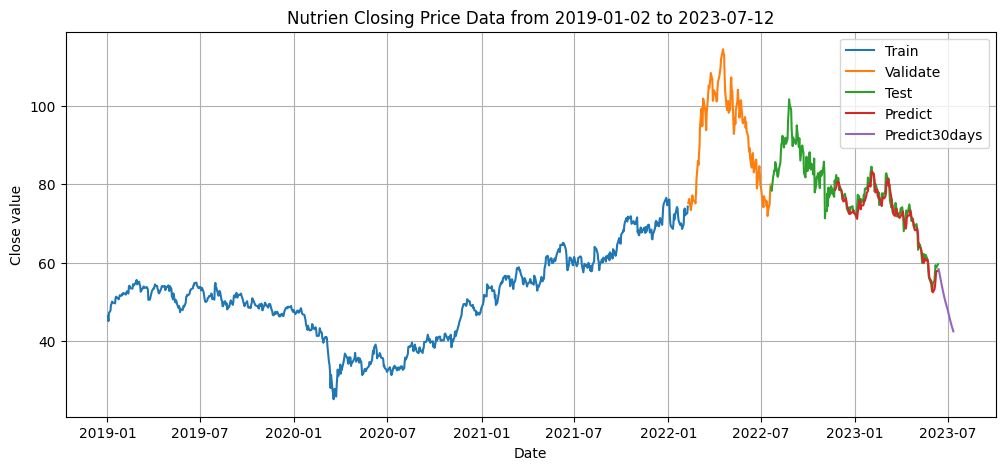

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + best_window_size: ], best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Nutrien Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_712_NTR.png')
plt.show()